## Code 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
import math
import re
import gc
import random
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rezka/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def randomize_data(inps, labels):
    even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    assert len(even_ind) == len(odd_ind)
    random.shuffle(even_ind)
    random.shuffle(odd_ind)
    shuffled_index = np.array([val for pair in zip(even_ind, odd_ind) for val in pair])
    return np.array(inps)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

In [95]:
# generate data
inps_t = []
labels_t = []
with open("dataset/subreg_test_2000.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps_t.append(inp)
        labels_t.append(lab)
inps_t, labels_t = randomize_data(inps_t, labels_t)

inps = []
labels = []
with open("dataset/subreg_train_2000.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps.append(inp)
        labels.append(lab)
inps, labels = randomize_data(inps, labels)

In [4]:
# in this case it is only six
all_characters = ['a','b','c','d','e','f','#','$']
n_letters = 8
categ = ['0', '1']
n_categories = 2
len_example = 40 # length of the grammars and example

# turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(n_letters).long()
    char_index = all_characters.index(string)
    tensor[char_index] = 1
    return tensor

def categories_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = categ.index(letter)
        tensor[li] = letter_index
    return tensor

def seq_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = all_characters.index(letter)
        tensor[li] = letter_index
    return tensor

In [5]:
def generate_batch(start_index, len_example, batch_size, inps, labels):
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, 1).long()
    for i in range(batch_size):
        inp = seq_tensor(inps[start_index+i])
        lab = categories_tensor(labels[start_index+i])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor, requires_grad=False).cuda(), Variable(lab_tensor, requires_grad=False).cuda()

In [6]:
def generate_random_batch(len_example, batch_size, inps, labels):
    even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    a = random.choice(even_ind, batch_size // 2)
    b = random.choice(odd_ind, batch_size // 2)
    random_index = np.concatenate([a,b])
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, 1).long()
    for i, ind in enumerate(random_index):
        inp = seq_tensor(inps[ind])
        lab = categories_tensor(labels[ind])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor, requires_grad=False).cuda(), Variable(lab_tensor, requires_grad=False).cuda()

In [7]:
def convert_string(texts):
    inp_tensor = torch.zeros(1, len_example).long()
    inp = seq_tensor(texts)
    inp_tensor[0,:] = inp
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor, requires_grad=False).cuda()

In [88]:
# hyperparameters
n_epochs = 20
n_hidden = 128
n_layers = 1
lr = 1e-3
clip = 0.25
batch_size = 200
dropout = 0.0
grammar_len = 20

print_every = 200

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2, dropout_p=0.2, grammar_len=15):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.input_dropout = nn.Dropout(p=dropout_p)
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(2*hidden_size, hidden_size, n_layers, dropout=dropout_p, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
        
        self.linear_out = nn.Linear(hidden_size*2, hidden_size)
        #self.combine_input = nn.Linear(hidden_size*2, hidden_size)
    
    def forward(self, input, hidden, batch_size, attn=False, context=None, combine=False, prev_ht=None):
        embedded = self.embed(input) # [batch_size, seq_len, embed_size]
        embedded = self.input_dropout(embedded)
        output = None
        
        if not attn:
            seq_len = embedded.size(1) 
            prev_ht = self.init_prev_ht(batch_size, seq_len)
            embedded = torch.cat((embedded, prev_ht), dim=2)
            ht, hidden = self.lstm(embedded, hidden) # [batch_size, seq_len, hidden_size]
            output = self.output(ht.squeeze(1))
        else:
            if combine:
                embedded = torch.cat((embedded, prev_ht), dim=2)
            ht, hidden = self.lstm(embedded, hidden) # [batch_size, 1, hidden_size]
            #print(ht)
            # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
            # in this case, in_len is the number of characters in total k-factors
            grammar_len = context.size(1)
            
            attn = torch.bmm(ht, context.transpose(1,2))
            #print(ht.size(), context.transpose(1,2).size())
            #print(attn)
            attn = F.softmax(attn.view(-1, grammar_len), dim=1).view(batch_size, -1, grammar_len)
            
            # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
            mix = torch.bmm(attn, context)
            
            # concat -> (batch, out_len, 2*dim)
            combined = torch.cat((mix, ht), dim=2)
            # output -> (batch, out_len, dim)
            ht = F.tanh(self.linear_out(combined.view(-1, 2 * self.hidden_size))).view(
                batch_size, -1, self.hidden_size)
            output = self.output(ht.squeeze(1))
            
        return output, ht, hidden

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        c0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        return h0, c0
    
    def init_prev_ht(self, batch_size, seq_len):
        ht = Variable(torch.zeros(batch_size, seq_len, self.hidden_size)).cuda()
        return ht

In [96]:
rnn = RNN(n_letters, n_hidden, n_categories, dropout_p=dropout)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [97]:
rnn.cuda()

RNN(
  (input_dropout): Dropout(p=0.0)
  (embed): Embedding(8, 128)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True)
  (output): Linear(in_features=128, out_features=2)
  (linear_out): Linear(in_features=256, out_features=128)
)

In [12]:
#start_index = 0
#hidden = rnn.init_hidden(batch_size)
#inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
#for c in range(len_example):
#    output, ht, hidden = rnn(inp[:,c].unsqueeze(1), hidden, batch_size)
#     print(inps[0][20+c])
# print(inps[0][20:])
#train(inp, target, attn=True)

In [13]:
# training
def train(inp, target, attn=False):
    loss = 0
    hidden = rnn.init_hidden(batch_size)
    rnn.zero_grad()
    cls = None
    if attn:
        #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
        i = 0
        output, ht, hidden = rnn(inp[:,:20], hidden, batch_size)
#         for j in range(ht.size(1)):
#             if j not in [3,7,11,15,19]:
#                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                 i += 1
        grammar_contexts = ht
        #print(grammar_contexts)
        ht = rnn.init_prev_ht(batch_size, 1)
        for c in range(len_example - 20):
            #print(ht)
            output, ht, hidden = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, combine=True, prev_ht=ht)
            #print(ht)
        cls = output
        cls = F.softmax(cls, dim=1)
    else:
        output, ht, hidden = rnn(inp, hidden, batch_size)
        cls = output[:,-1,:].contiguous()
        cls = F.softmax(cls, dim=1) 
    
    loss = criterion(cls.view(batch_size, -1), target.squeeze(1))
    loss.backward()
    rnn_optimizer.step()

    return loss.data[0], ht, hidden

In [14]:
# batch_size = 4
# start_index = 0
# hidden = rnn.init_hidden(batch_size)
# inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
# train(inp, target, attn=True)

In [15]:
def repackage_hidden(h, c):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data), Variable(c.data)
    else:
        return tuple(repackage_hidden(v) for v in h), tuple(repackage_hidden(u) for u in c)

In [16]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [17]:
def accuracy_test_data(attn=False):
    batch_size = 400
    it = len(inps_t) / batch_size
    acc_tot = 0
    for i in range(int(it)):
        cls = None
        hidden = rnn.init_hidden(batch_size)
        start_index = i * batch_size
        inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps_t, labels_t)
        
        if attn:
            #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
            i = 0
            output, ht, hidden = rnn(inp_t[:,:20], hidden, batch_size)
    #         for j in range(ht.size(1)):
    #             if j not in [3,7,11,15,19]:
    #                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
    #                 i += 1
            grammar_contexts = ht
            #print(grammar_contexts)
            ht = rnn.init_prev_ht(batch_size, 1)
            for c in range(len_example - 20):
                #print(ht)
                output, ht, hidden = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, combine=True, prev_ht=ht)
                #print(ht)
            cls = output
            cls = F.softmax(cls, dim=1)
        else:
            output, ht, hidden = rnn(inp_t, hidden, batch_size)
            cls = output[:,-1,:].contiguous()
            cls = F.softmax(cls, dim=1)
            
        max_idx = cls.max(1)[1]
        accuracy = (lab_t.squeeze() == max_idx).long().sum().float() / batch_size
        acc_tot += accuracy.data[0] #, max_idx.sum().data[0]
    return acc_tot / it

In [18]:
def accuracy_train_data(attn=False):
    batch_size = 1000
    it = len(inps) / batch_size
    acc_tot = 0
    for i in range(int(it)):
        cls = None
        hidden = rnn.init_hidden(batch_size)
        start_index = i * batch_size
        inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps, labels)
        
        if attn:
            #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
            i = 0
            output, ht, hidden = rnn(inp_t[:,:20], hidden, batch_size)
#             for j in range(ht.size(1)):
#                 if j not in [3,7,11,15,19]:
#                     grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                     i += 1
            grammar_contexts = ht
            #print(grammar_contexts)
            ht = rnn.init_prev_ht(batch_size, 1)
            for c in range(len_example - 20):
                #print(ht)
                output, ht, hidden = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, combine=True, prev_ht=ht)
                #print(ht)
            cls = output
            cls = F.softmax(cls, dim=1)
        else:
            output, ht, hidden = rnn(inp_t, hidden, batch_size)
            cls = output[:,-1,:].contiguous()
            cls = F.softmax(cls, dim=1)
        
        max_idx = cls.max(1)[1]
        accuracy = (lab_t.squeeze() == max_idx).long().sum().float()
        acc_tot += accuracy.data[0] #, max_idx.sum().data[0]
    return acc_tot / len(inps)

In [98]:
batch_size = 200
start = time.time()
iters = 0
rnn.train(True)
losses, accs, accs_tr = [], [], []
attn = True
for epoch in range(1, n_epochs + 1):
    start_index = 0
    steps = len(inps) / batch_size
    for i in range(int(steps)):
        start_index = i * batch_size
        inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
        loss, _, _ = train(inp, target, attn=attn)
        losses.append(loss)
        if iters % print_every == 0:
            acc = accuracy_test_data(attn=attn)
            acc_tr = accuracy_train_data(attn=attn)
            accs.append(acc)
            accs_tr.append(acc_tr)
            print("Loss {}, Test Accuracy {}, Train Accuracy {}".format(loss, acc, acc_tr))

        iters += 1
acc = accuracy_test_data(attn=attn)
acc_tr = accuracy_train_data(attn=attn)
accs.append(acc)
accs_tr.append(acc_tr)

Loss 0.6930896639823914, Test Accuracy 0.5036249861121178, Train Accuracy 0.50240625
Loss 0.6806796193122864, Test Accuracy 0.5828749805688858, Train Accuracy 0.5839375
Loss 0.5940182209014893, Test Accuracy 0.6416249811649323, Train Accuracy 0.6610625
Loss 0.5063607692718506, Test Accuracy 0.7732499897480011, Train Accuracy 0.78559375
Loss 0.45662131905555725, Test Accuracy 0.8676249861717225, Train Accuracy 0.87371875
Loss 0.3523038625717163, Test Accuracy 0.9323749810457229, Train Accuracy 0.94190625
Loss 0.4295346438884735, Test Accuracy 0.9153749704360962, Train Accuracy 0.92178125
Loss 0.40617671608924866, Test Accuracy 0.9107499688863754, Train Accuracy 0.91296875
Loss 0.38156771659851074, Test Accuracy 0.9243749707937241, Train Accuracy 0.933
Loss 0.3511452078819275, Test Accuracy 0.938374987244606, Train Accuracy 0.9423125
Loss 0.48193344473838806, Test Accuracy 0.8291249841451644, Train Accuracy 0.83246875
Loss 0.49931490421295166, Test Accuracy 0.8277499854564667, Train Accu

In [19]:
# predicted 
# start_index = 0
# batch_size = 10
# it = len(inps_t) / batch_size
# acc_tot = 0
# cls = None
# hidden = rnn.init_hidden(batch_size)
# inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps_t, labels_t)
# attn=False
# rnn.zero_grad()

# if attn:
#     grammar_contexts = Variable(torch.zeros(grammar_len, batch_size, n_hidden)).cuda()
#     i = 0
#     output, ht, hidden = rnn(inp_t[:,:20], hidden, batch_size)
#     #for j in range(ht.size(1)):
#     #    if j not in [3,7,11,15,18]:
#     #        grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#     #        i += 1
#     grammar_contexts = ht
#     ht = rnn.init_prev_ht(batch_size, 1)
#     for c in range(len_example - 20):
#         output, ht, hidden = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
#                              context=grammar_contexts, combine=True, prev_ht=ht)
#     cls = output
#     #print(F.softmax(cls, dim=1))
# else:
#     output, ht, hidden = rnn(inp_t, hidden, batch_size)
#     cls = output[:,-1,:].contiguous()
#     #print(F.softmax(cls, dim=1))

# max_idx = cls.max(1)[1]
# for i in range(batch_size):
#     print(inps_t[start_index+i], max_idx.data[i], lab_t.squeeze().data[i])
# accuracy = (lab_t.squeeze() == max_idx).long().sum().float()
# print(accuracy.data[0] / batch_size)

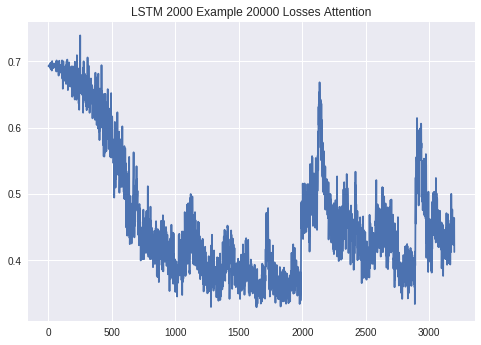

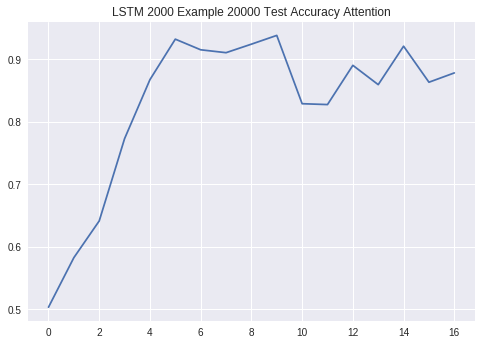

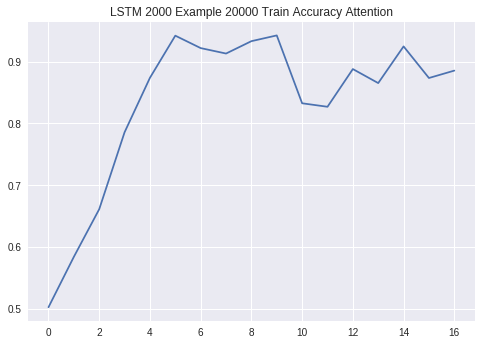

In [99]:
## plots
plt.plot(np.arange(len(losses)), losses)
plt.title('LSTM 2000 Example 20000 Losses Attention')
plt.savefig("plots/lstm_2000example_20000c_losses_attn.png")
plt.show()

plt.plot(np.arange(len(accs)), accs)
plt.title('LSTM 2000 Example 20000 Test Accuracy Attention')
plt.savefig("plots/lstm_2000example_20000c_test_acc_attn.png")
plt.show()

plt.plot(np.arange(len(accs_tr)), accs_tr)
plt.title('LSTM 2000 Example 20000 Train Accuracy Attention')
plt.savefig("plots/lstm_2000example_20000c_train_acc_attn.png")
plt.show()

In [100]:
with open('models/lstm_2000example_20000c_attn.tar','wb') as ckpt:
     torch.save(rnn, ckpt)

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Analysis and Diagnostic Classifier

In [28]:
from sklearn import metrics
from scipy import stats
import scipy as sp

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from scipy.stats import pearsonr

import seaborn as sns

In [18]:
rnn = torch.load('models/lstm_2000example_20000c.tar').cuda()

In [29]:
def hypothesis_k_factors(text):
    return np.array([-1 if x == '#' or x == '$' else 1 for x in text])

def hypothesis_detect_k_factors(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
    return hyp

def hypothesis_match_grammar(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
            for i, j in zip(range(len(kf)), reversed(range(len(kf)))):
                if j != 0:
                    ind = [m.start() for m in re.finditer(kf[:-j], text)]
                    print(ind, kf[:-j], i)
                    for el in ind:
                        hyp[el:el+i] = 1
    return hyp

In [67]:
hypothesis_match_grammar("bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb")

[8, 9, 12, 24, 28] c 0
[12, 28] cd 1


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

In [30]:
def validate_hypothesis(model, diag_classifier, hypothesis, train_len=50,
                        test_len=1, tt=None, save_hyp=None, save_diag=None, save_resp=None):
    # Generate hypothesis data
    def gen_hyp_data(model, N, hypothesis, start_index):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        inp, target = generate_random_batch(len_example, N, inps, labels)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(inp[i])):
                _, hidden, cell = rnn(inp[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(inps[i])
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(inps[i])
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)
    
    def gen_hyp_data_test(model, N, hypothesis, tt):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        tensor_tt = convert_string(tt)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(tensor_tt[i])):
                _, hidden, cell = rnn(tensor_tt[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(tt)
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(tt)
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)

    # Generate train and test data
    _, train_hyps, train_hiddens, train_hiddens_2 = gen_hyp_data(model, train_len, hypothesis, 0)
    test_texts, test_hyps, test_hiddens, test_hiddens_2 = gen_hyp_data_test(model, test_len, hypothesis, tt)
    #print(pearsonr(train_hiddens, train_hyps))
    #print(pearsonr(test_hiddens, test_hyps))

    # Train Diagnostic Classifier
    diag_classifier.fit(train_hiddens, train_hyps)
    
    # Predict with Diagnostic Classifier
    pred_hyps = diag_classifier.predict(test_hiddens)
    
    # Find responsible neuron
    resp_neuron = np.argmax(np.abs(diag_classifier.coef_))
    print(resp_neuron)
    
    # Plot results
    if save_hyp:
        plot_colored_text(test_texts[:len_example], test_hyps[:len_example],
                          title='Formed Hypothesis',
                          save_file=save_hyp)
    if save_diag:
        plot_colored_text(test_texts[:len_example], pred_hyps[:len_example],
                          title='Diagnostic Classifier Prediction',
                          save_file=save_diag)
    if save_resp:
        plot_colored_text(test_texts[:len_example], test_hiddens[:len_example, resp_neuron],
                          title='Most Responsible Neuron {}'.format(resp_neuron),
                          save_file=save_resp)
        
    del(train_hyps)
    del(train_hiddens)
    del(test_texts)
    del(test_hiddens)
    gc.collect()
    
    return test_hyps, pred_hyps

In [31]:
### PLOTTING HELPERS ###
def wrap_colored_text(text, colors, W, tabsize=4):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []

    # Wrap lines to width
    for char, color in zip(text, colors):
        if char == '\t':
            for i in range(tabsize):
                new_text.append(' ')
                new_colors.append(color)
        else:
            new_text.append(char)
            new_colors.append(color)
            if char == '\n':
                for i in range(W - len(new_text) % W):
                    new_text.append(' ')
                    new_colors.append(np.zeros_like(colors[0]))

    # Add final space to obtain (rectangular) matrix
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))

    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

def plot_colored_text(text, colors, W=80, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_text(text, colors, W, tabsize=4)

    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))

    color_palette = sns.color_palette("RdBu_r", 255, desat=.9)
    color_palette[127] = (1.,1.,1.) # set zero to white color
    sns.heatmap(wrapped_colors, annot=wrapped_text,
                annot_kws={'color':'black',
                           'family':'monospace',
                           'horizontalalignment':'center',
                           'fontweight':'light'},
                fmt='s', cbar=False, vmin=-2, vmax=2)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [32]:
model_name = "lstm_2000example_20000c_attn"
hyp_name = "detect_k_factors"
y_true, y_pred = validate_hypothesis(rnn, LogisticRegression(), hypothesis_detect_k_factors,
                                         train_len=1000, test_len=1, tt="bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb",
                                         save_hyp='plots/{}_hyp_{}.png'.format(model_name, hyp_name),
                                         save_diag='plots/{}_diag_{}.png'.format(model_name, hyp_name),
                                         save_resp='plots/{}_resp_{}.png'.format(model_name, hyp_name))

ValueError: not enough values to unpack (expected 2, got 0)

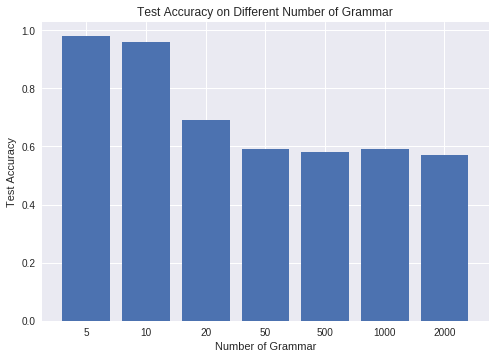

In [114]:
acc_test = [0.98, 0.96, 0.69, 0.59, 0.58, 0.59, 0.57]
experiment = [5, 10, 20, 50, 500, 1000, 2000]
x = np.arange(len(acc_test))
plt.bar(x, acc_test)
plt.xticks(x, experiment)
plt.xlabel('Number of Grammar')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy on Different Number of Grammar')
plt.savefig("plots/lstm_test_acc_bar.png")
plt.show()